<a href="https://colab.research.google.com/github/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/course_project_template_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning in Human Language Technology Project (Template)

- Student(s) name(s):
- Date:
- Chosen Corpus:
- Contributions (if group project):

### Corpus information

- Description of the chosen corpus:
- Paper(s) and other published materials related to the corpus:
- Random baseline performance and expected performance for recent machine learned models:

---

## 1. Setup

In [6]:
# Your code to install and import libraries etc. here
# Section 1: Setup
# This cell installs and imports all necessary libraries

# Install required libraries
!pip install -q transformers datasets accelerate evaluate scikit-learn

# Core libraries
import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import json

# Hugging Face libraries
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM,           # For generative models (SmolLM, DistilGPT2)
    AutoModelForSequenceClassification,  # For BERT models
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding,
    pipeline
)
from datasets import load_dataset
import evaluate

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB


---

## 2. Data download, sampling and preprocessing

### 2.1. Download the corpus

In [7]:
# Your code to download the corpus here
# Section 2.1: Download Rotten Tomatoes dataset

# Load dataset from Hugging Face Hub
dataset = load_dataset("rotten_tomatoes")

# Display dataset structure
print("Dataset structure:")
print(dataset)
print("\n" + "="*50 + "\n")

# Show example from each split
print("Example from training set:")
print(dataset['train'][0])
print("\n" + "="*50 + "\n")

# Display split sizes
print("Split sizes:")
for split in ['train', 'validation', 'test']:
    print(f"{split}: {len(dataset[split])} examples")

README.md: 0.00B [00:00, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})


Example from training set:
{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}


Split sizes:
train: 8530 examples
validation: 1066 examples
test: 1066 examples


### 2.2. Sampling and preprocessing

ROTTEN TOMATOES DATASET - LABEL DISTRIBUTION

TRAIN SET:
  Total examples: 8530
  Negative (0): 4265 (50.00%)
  Positive (1): 4265 (50.00%)
  Balance: BALANCED

VALIDATION SET:
  Total examples: 1066
  Negative (0): 533 (50.00%)
  Positive (1): 533 (50.00%)
  Balance: BALANCED

TEST SET:
  Total examples: 1066
  Negative (0): 533 (50.00%)
  Positive (1): 533 (50.00%)
  Balance: BALANCED



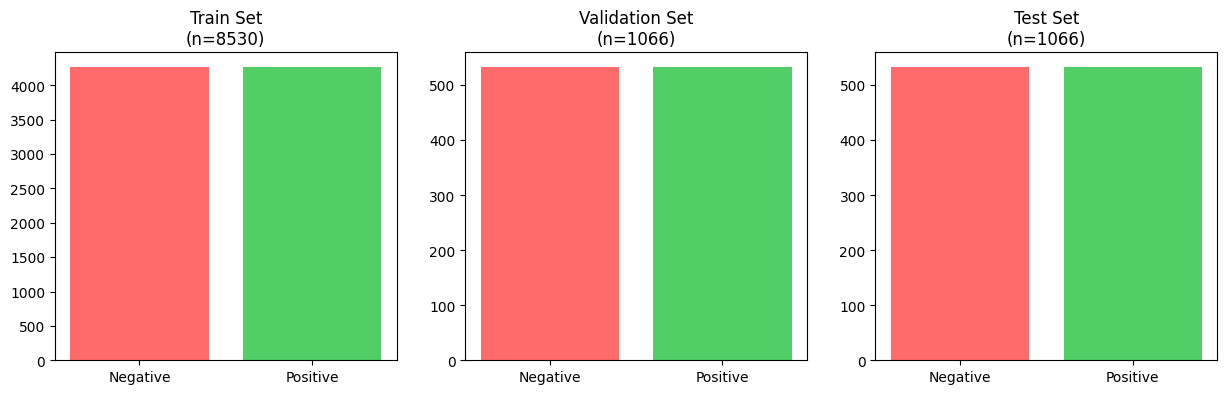

In [8]:
# Your code for any necessary sampling and preprocessing here

# =============================================================================

def analyze_label_distribution(dataset):
    """Analyze and visualize label distribution across all splits"""
    
    results = {}
    
    for split in ['train', 'validation', 'test']:
        labels = dataset[split]['label']
        label_counts = Counter(labels)
        
        results[split] = {
            'total': len(labels),
            'negative (0)': label_counts[0],
            'positive (1)': label_counts[1],
            'negative_pct': (label_counts[0] / len(labels)) * 100,
            'positive_pct': (label_counts[1] / len(labels)) * 100
        }
    
    return results

# Analyze distribution
distribution = analyze_label_distribution(dataset)

# Print statistics
print("="*70)
print("ROTTEN TOMATOES DATASET - LABEL DISTRIBUTION")
print("="*70)
for split, stats in distribution.items():
    print(f"\n{split.upper()} SET:")
    print(f"  Total examples: {stats['total']}")
    print(f"  Negative (0): {stats['negative (0)']} ({stats['negative_pct']:.2f}%)")
    print(f"  Positive (1): {stats['positive (1)']} ({stats['positive_pct']:.2f}%)")
    print(f"  Balance: {'BALANCED' if abs(stats['negative_pct'] - 50) < 5 else 'IMBALANCED'}")

print("\n" + "="*70)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, split in enumerate(['train', 'validation', 'test']):
    stats = distribution[split]
    axes[idx].bar(['Negative', 'Positive'], 
                  [stats['negative (0)'], stats['positive (1)']], 
                  color=['#ff6b6b', '#51cf66'])
    axes[idx].set_title(f'{split.capitalize()} Set\n(n={stats["total"]})')
    axes

---

## 3. Prompting a generative model (smolLM)

### 3.1 Prompt optimization

Loading SmolLM-135M-Instruct...
Model loaded on: cuda:0
Model parameters: 134.5M
PROMPT OPTIMIZATION ON VALIDATION SET

Evaluating 0-shot prompting on 1066 examples...


  0%|          | 0/1066 [00:00<?, ?it/s]


0-shot Results:
  Accuracy: 0.5366
  Negative Accuracy: 0.7974
  Positive Accuracy: 0.2758
  Failed Parses: 804 (75.42%)

Evaluating 2-shot prompting on 1066 examples...


  0%|          | 0/1066 [00:00<?, ?it/s]


2-shot Results:
  Accuracy: 0.6707
  Negative Accuracy: 0.4728
  Positive Accuracy: 0.8687
  Failed Parses: 13 (1.22%)

Evaluating 4-shot prompting on 1066 examples...


  0%|          | 0/1066 [00:00<?, ?it/s]


4-shot Results:
  Accuracy: 0.7392
  Negative Accuracy: 0.8743
  Positive Accuracy: 0.6041
  Failed Parses: 0 (0.00%)

BEST APPROACH: 4-shot prompting
Validation Accuracy: 0.7392


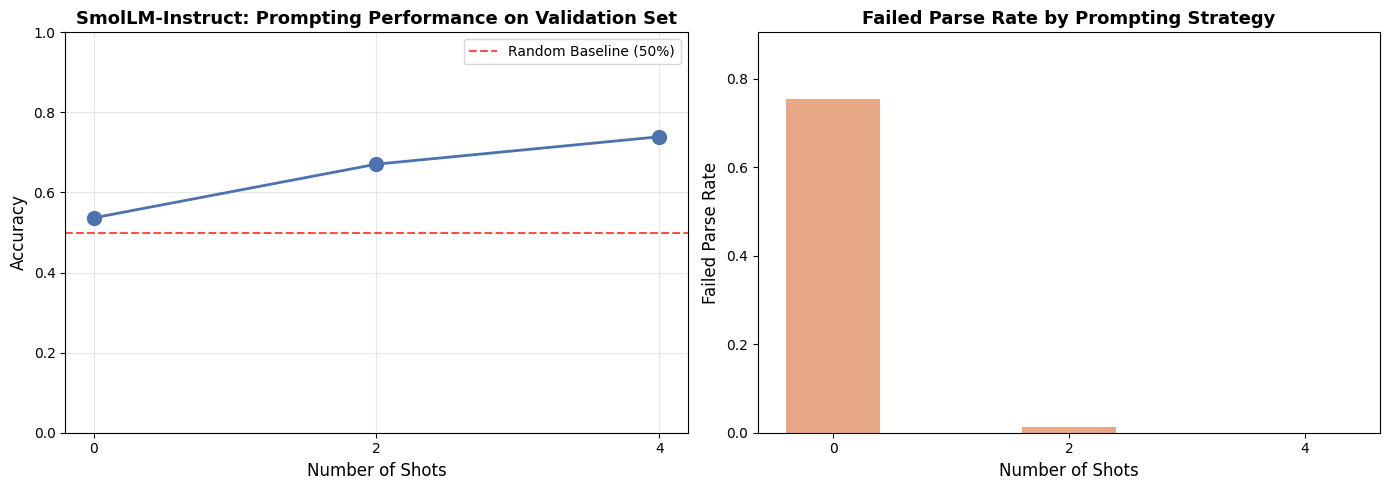

In [9]:
# Your code and experiments relating to the prompt optimization here
# Section 3.1: Prompt Optimization for SmolLM-Instruct

# =============================================================================
# LOAD MODEL
# =============================================================================

print("Loading SmolLM-135M-Instruct...")
model_name = "HuggingFaceTB/SmolLM-135M-Instruct"

tokenizer_smol = AutoTokenizer.from_pretrained(model_name)
model_smol = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  # Use FP16 for faster inference
    device_map="auto"            # Automatically use GPU
)

# Set padding token (required for batch processing)
if tokenizer_smol.pad_token is None:
    tokenizer_smol.pad_token = tokenizer_smol.eos_token
    model_smol.config.pad_token_id = tokenizer_smol.eos_token_id

print(f"Model loaded on: {model_smol.device}")
print(f"Model parameters: {model_smol.num_parameters() / 1e6:.1f}M")

# =============================================================================
# DEFINE PROMPTING FUNCTIONS
# =============================================================================

def create_prompt(text, examples=None):
    """
    Create a prompt for sentiment classification
    
    Args:
        text: The review text to classify
        examples: List of (text, label) tuples for few-shot examples (None for zero-shot)
    
    Returns:
        Formatted prompt string
    """
    
    # System instruction
    prompt = "Classify the sentiment of movie reviews as either 'positive' or 'negative'.\n\n"
    
    # Add few-shot examples if provided
    if examples:
        prompt += "Examples:\n"
        for ex_text, ex_label in examples:
            label_name = "positive" if ex_label == 1 else "negative"
            prompt += f"Review: {ex_text}\nSentiment: {label_name}\n\n"
    
    # Add the review to classify
    prompt += f"Review: {text}\nSentiment:"
    
    return prompt


def generate_prediction(model, tokenizer, prompt, max_new_tokens=10):
    """
    Generate prediction from the model
    
    Args:
        model: The language model
        tokenizer: The tokenizer
        prompt: Input prompt
        max_new_tokens: Maximum tokens to generate
    
    Returns:
        Generated text (just the completion, not the full prompt)
    """
    
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            #temperature=0.1,      # Low temperature for more deterministic outputs
            do_sample=False,      # Greedy decoding for consistency
            pad_token_id=tokenizer.pad_token_id
        )
    
    # Decode only the generated part (exclude the prompt)
    generated_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    
    return generated_text.strip()


def parse_sentiment(generated_text):
    """
    Parse the generated text to extract sentiment label
    
    Returns:
        0 for negative, 1 for positive, None if parsing fails
    """
    
    text_lower = generated_text.lower()
    
    # Check for clear positive/negative indicators
    if 'positive' in text_lower and 'negative' not in text_lower:
        return 1
    elif 'negative' in text_lower and 'positive' not in text_lower:
        return 0
    else:
        # Unparseable output
        return None


def evaluate_prompting(model, tokenizer, dataset_split, num_shots=0, num_samples=None):
    """
    Evaluate prompting approach on a dataset split
    
    Args:
        model: The language model
        tokenizer: The tokenizer
        dataset_split: Dataset split to evaluate on
        num_shots: Number of few-shot examples (0, 2, or 4)
        num_samples: Limit evaluation to N samples (None for all)
    
    Returns:
        Dictionary with results
    """
    
    # Select few-shot examples from training set (same for all test examples)
    few_shot_examples = None
    if num_shots > 0:
        # Select balanced examples (equal positive and negative)
        train_data = dataset['train']
        neg_examples = [(train_data[i]['text'], 0) for i in range(len(train_data)) if train_data[i]['label'] == 0]
        pos_examples = [(train_data[i]['text'], 1) for i in range(len(train_data)) if train_data[i]['label'] == 1]
        
        # Take first num_shots/2 from each class
        few_shot_examples = neg_examples[:num_shots//2] + pos_examples[:num_shots//2]
    
    # Limit samples if specified
    data = dataset_split if num_samples is None else dataset_split.select(range(min(num_samples, len(dataset_split))))
    
    predictions = []
    true_labels = []
    failed_parses = 0
    
    print(f"\nEvaluating {num_shots}-shot prompting on {len(data)} examples...")
    
    for example in tqdm(data):
        text = example['text']
        true_label = example['label']
        
        # Create prompt
        prompt = create_prompt(text, examples=few_shot_examples)
        
        # Generate prediction
        generated = generate_prediction(model, tokenizer, prompt)
        predicted_label = parse_sentiment(generated)
        
        # Track failed parses
        if predicted_label is None:
            failed_parses += 1
            # Default to majority class (0) for failed parses
            predicted_label = 0
        
        predictions.append(predicted_label)
        true_labels.append(true_label)
    
    # Calculate metrics
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    accuracy = (predictions == true_labels).mean()
    
    # Per-class accuracy
    neg_mask = true_labels == 0
    pos_mask = true_labels == 1
    neg_accuracy = (predictions[neg_mask] == true_labels[neg_mask]).mean() if neg_mask.sum() > 0 else 0
    pos_accuracy = (predictions[pos_mask] == true_labels[pos_mask]).mean() if pos_mask.sum() > 0 else 0
    
    results = {
        'num_shots': num_shots,
        'accuracy': accuracy,
        'negative_accuracy': neg_accuracy,
        'positive_accuracy': pos_accuracy,
        'failed_parses': failed_parses,
        'failed_parse_rate': failed_parses / len(data),
        'predictions': predictions,
        'true_labels': true_labels
    }
    
    return results

# =============================================================================
# TEST DIFFERENT PROMPTING STRATEGIES ON VALIDATION SET
# =============================================================================

print("="*70)
print("PROMPT OPTIMIZATION ON VALIDATION SET")
print("="*70)

validation_results = {}

for num_shots in [0, 2, 4]:
    results = evaluate_prompting(
        model_smol, 
        tokenizer_smol, 
        dataset['validation'], 
        num_shots=num_shots
    )
    validation_results[num_shots] = results
    
    print(f"\n{num_shots}-shot Results:")
    print(f"  Accuracy: {results['accuracy']:.4f}")
    print(f"  Negative Accuracy: {results['negative_accuracy']:.4f}")
    print(f"  Positive Accuracy: {results['positive_accuracy']:.4f}")
    print(f"  Failed Parses: {results['failed_parses']} ({results['failed_parse_rate']:.2%})")

# =============================================================================
# SELECT BEST APPROACH
# =============================================================================

best_num_shots = max(validation_results.keys(), key=lambda k: validation_results[k]['accuracy'])
best_val_accuracy = validation_results[best_num_shots]['accuracy']

print("\n" + "="*70)
print(f"BEST APPROACH: {best_num_shots}-shot prompting")
print(f"Validation Accuracy: {best_val_accuracy:.4f}")
print("="*70)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy comparison
shots = list(validation_results.keys())
accuracies = [validation_results[s]['accuracy'] for s in shots]
ax1.plot(shots, accuracies, marker='o', linewidth=2, markersize=10, color='#4c72b0')
ax1.axhline(y=0.5, color='red', linestyle='--', label='Random Baseline (50%)', alpha=0.7)
ax1.set_xlabel('Number of Shots', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('SmolLM-Instruct: Prompting Performance on Validation Set', fontsize=13, fontweight='bold')
ax1.set_xticks(shots)
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Failed parse rates
failed_rates = [validation_results[s]['failed_parse_rate'] for s in shots]
ax2.bar(shots, failed_rates, color='#dd8452', alpha=0.7)
ax2.set_xlabel('Number of Shots', fontsize=12)
ax2.set_ylabel('Failed Parse Rate', fontsize=12)
ax2.set_title('Failed Parse Rate by Prompting Strategy', fontsize=13, fontweight='bold')
ax2.set_xticks(shots)
ax2.set_ylim(0, max(failed_rates) * 1.2 if max(failed_rates) > 0 else 0.1)

plt.tight_layout()
plt.savefig('smol_prompting_validation.png', dpi=100, bbox_inches='tight')
plt.show()

### 3.2 Evaluation on test set

In [ ]:
# Section 3.2: Evaluation on Test Set (SmolLM Prompting)

print("="*70)
print("SMOLLM-INSTRUCT: 4-SHOT PROMPTING - TEST SET EVALUATION")
print("="*70)

# Evaluate best approach on test set
test_results_smol_prompt = evaluate_prompting(
    model_smol, 
    tokenizer_smol, 
    dataset['test'], 
    num_shots=4  # Best approach from validation
)

print(f"\n{'='*70}")
print("FINAL TEST RESULTS:")
print(f"{'='*70}")
print(f"Accuracy: {test_results_smol_prompt['accuracy']:.4f}")
print(f"Negative Accuracy: {test_results_smol_prompt['negative_accuracy']:.4f}")
print(f"Positive Accuracy: {test_results_smol_prompt['positive_accuracy']:.4f}")
print(f"Failed Parses: {test_results_smol_prompt['failed_parses']} ({test_results_smol_prompt['failed_parse_rate']:.2%})")
print(f"{'='*70}")

# Store predictions for later error analysis (Section 8)
smol_prompt_predictions = {
    'model': 'SmolLM-Instruct (4-shot prompting)',
    'predictions': test_results_smol_prompt['predictions'],
    'true_labels': test_results_smol_prompt['true_labels'],
    'accuracy': test_results_smol_prompt['accuracy'],
    'failed_parses': test_results_smol_prompt['failed_parses']
}

# Save to file for persistence
import pickle
with open('smol_prompt_predictions.pkl', 'wb') as f:
    pickle.dump(smol_prompt_predictions, f)

print("\n✓ Predictions saved for error analysis")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(test_results_smol_prompt['true_labels'], 
                      test_results_smol_prompt['predictions'])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('SmolLM-Instruct (4-shot Prompting) - Test Set Confusion Matrix', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('smol_prompt_confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(test_results_smol_prompt['true_labels'], 
                           test_results_smol_prompt['predictions'],
                           target_names=['Negative', 'Positive']))

# Clean up model from memory before next section
del model_smol
torch.cuda.empty_cache()
print("\n✓ Model removed from memory")

---

## 4. Fine-tuning a generative model

### 4.1. Model training

In [24]:
# MEMORY CLEANUP CELL - Run this before fine-tuning

import gc

# Clear Python memory
gc.collect()

# Clear CUDA cache
torch.cuda.empty_cache()

# Check memory status
if torch.cuda.is_available():
    print("GPU Memory Status:")
    print(f"  Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"  Cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
    print(f"  Free: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated()) / 1e9:.2f} GB")
    
# Reset PyTorch
torch.cuda.reset_peak_memory_stats()
print("\n✓ Memory cleared")

GPU Memory Status:
  Allocated: 1.11 GB
  Cached: 2.31 GB
  Free: 14.72 GB

✓ Memory cleared


### 4.2 Hyperparameter optimization

In [ ]:
# Section 4.1 & 4.2: Fine-tuning SmolLM (MEMORY OPTIMIZED)

# =============================================================================
# RELOAD MODEL AND TOKENIZER
# =============================================================================

print("Loading SmolLM-135M-Instruct for fine-tuning...")
model_name = "HuggingFaceTB/SmolLM-135M-Instruct"

tokenizer_smol_ft = AutoTokenizer.from_pretrained(model_name)
if tokenizer_smol_ft.pad_token is None:
    tokenizer_smol_ft.pad_token = tokenizer_smol_ft.eos_token

print("✓ Tokenizer loaded")

# =============================================================================
# PREPARE DATASET FOR FINE-TUNING
# =============================================================================

def format_instruction_dataset(examples):
    """Format examples as instruction-following prompts"""
    texts = []
    for text, label in zip(examples['text'], examples['label']):
        sentiment = "positive" if label == 1 else "negative"
        formatted = f"Classify the sentiment of this movie review as positive or negative.\nReview: {text}\nSentiment: {sentiment}"
        texts.append(formatted)
    return {"formatted_text": texts}

# Apply formatting
train_dataset_ft = dataset['train'].map(format_instruction_dataset, batched=True)
val_dataset_ft = dataset['validation'].map(format_instruction_dataset, batched=True)
test_dataset_ft = dataset['test'].map(format_instruction_dataset, batched=True)

print(f"✓ Formatted {len(train_dataset_ft)} training examples")

# =============================================================================
# TOKENIZATION
# =============================================================================

def tokenize_function(examples):
    """Tokenize and mask instruction part - only compute loss on sentiment label"""
    
    # Tokenize the full formatted text
    tokenized = tokenizer_smol_ft(
        examples['formatted_text'],
        truncation=True,
        max_length=256,
        padding='max_length',
        return_tensors=None
    )
    
    # Create labels - initialize with -100 (ignore index)
    labels = []
    
    for i, formatted_text in enumerate(examples['formatted_text']):
        # Find where "Sentiment: " ends and the actual label begins
        sentiment_start = formatted_text.rfind("Sentiment: ") + len("Sentiment: ")
        
        # Tokenize just the prompt part (everything before the label)
        prompt_part = formatted_text[:sentiment_start]
        prompt_tokens = tokenizer_smol_ft(prompt_part, add_special_tokens=False)['input_ids']
        prompt_length = len(prompt_tokens)
        
        # Create label sequence
        input_ids = tokenized['input_ids'][i]
        label_seq = [-100] * len(input_ids)  # Start with all ignored
        
        # Only compute loss on the completion part (after prompt)
        for j in range(prompt_length, len(input_ids)):
            if input_ids[j] != tokenizer_smol_ft.pad_token_id:
                label_seq[j] = input_ids[j]
            else:
                label_seq[j] = -100  # Mask padding tokens
        
        labels.append(label_seq)
    
    tokenized['labels'] = labels
    return tokenized

train_tokenized = train_dataset_ft.map(tokenize_function, batched=True, remove_columns=train_dataset_ft.column_names)
val_tokenized = val_dataset_ft.map(tokenize_function, batched=True, remove_columns=val_dataset_ft.column_names)
test_tokenized = test_dataset_ft.map(tokenize_function, batched=True, remove_columns=test_dataset_ft.column_names)

print("✓ Datasets tokenized")

# =============================================================================
# REDUCED HYPERPARAMETER GRID (Memory optimized)
# =============================================================================

print("\n" + "="*70)
print("HYPERPARAMETER SEARCH (MEMORY OPTIMIZED)")
print("="*70)

# REDUCED grid to save time and memory
learning_rates = [2e-5, 5e-5]  # Reduced from 3 to 2
batch_sizes = [4]  # Reduced from [8, 16] to just 4 with gradient accumulation
num_epochs_list = [3, 5]  # Keep both

# Total: 2 × 1 × 2 = 4 configurations instead of 12

best_val_loss = float('inf')
best_hyperparams = None
hyperparameter_results = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        for num_epochs in num_epochs_list:
            
            print(f"\n{'='*70}")
            print(f"Testing: LR={lr}, Batch Size={batch_size} (effective: 16 with grad_accum), Epochs={num_epochs}")
            print(f"{'='*70}")
            
            # Load fresh model
            model_ft = AutoModelForCausalLM.from_pretrained(
                model_name,
                torch_dtype=torch.float16,  # FP16 for memory efficiency
                device_map="auto"
            )
            
            # Training arguments with gradient accumulation
            training_args = TrainingArguments(
                output_dir=f"./smol_ft_lr{lr}_bs{batch_size}_ep{num_epochs}",
                learning_rate=lr,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size,
                gradient_accumulation_steps=4,  # Effective batch size = 4 * 4 = 16
                num_train_epochs=num_epochs,
                eval_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="eval_loss",
                logging_steps=100,
                save_total_limit=1,
                fp16=not torch.cuda.is_bf16_supported(),
                bf16 = torch.cuda.is_bf16_supported(),
                report_to="none",
                disable_tqdm=False,
                gradient_checkpointing=True,  # Save memory during backprop
                optim="adamw_torch",  # Memory efficient optimizer
                max_grad_norm=1.0,  # ADD: Gradient clipping for stability
                warmup_steps=50, 

            )
            
            # Initialize Trainer
            trainer = Trainer(
                model=model_ft,
                args=training_args,
                train_dataset=train_tokenized,
                eval_dataset=val_tokenized,
                tokenizer=tokenizer_smol_ft,
            )
            
            # Train
            print("Starting training...")
            train_result = trainer.train()
            
            # Evaluate
            eval_result = trainer.evaluate()
            val_loss = eval_result['eval_loss']
            
            print(f"\nValidation Loss: {val_loss:.4f}")
            print(f"Training Loss: {train_result.training_loss:.4f}")
            
            # Store results
            hyperparameter_results.append({
                'lr': lr,
                'batch_size': f"{batch_size} (eff: 16)",
                'num_epochs': num_epochs,
                'val_loss': val_loss,
                'train_loss': train_result.training_loss
            })
            
            # Track best
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_hyperparams = {
                    'lr': lr,
                    'batch_size': batch_size,
                    'num_epochs': num_epochs,
                    'model_path': training_args.output_dir
                }
                trainer.save_model("./smol_ft_best_model")
                tokenizer_smol_ft.save_pretrained("./smol_ft_best_model")
                print(f"✓ New best model saved! (Val Loss: {val_loss:.4f})")
            
            # AGGRESSIVE CLEANUP
            del model_ft
            del trainer
            torch.cuda.empty_cache()
            gc.collect()
            
            print(f"GPU Memory after cleanup: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

# =============================================================================
# RESULTS
# =============================================================================

print("\n" + "="*70)
print("HYPERPARAMETER SEARCH RESULTS")
print("="*70)

results_df = pd.DataFrame(hyperparameter_results)
results_df = results_df.sort_values('val_loss')
print(results_df.to_string(index=False))

print(f"\n{'='*70}")
print("BEST HYPERPARAMETERS:")
print(f"{'='*70}")
print(f"Learning Rate: {best_hyperparams['lr']}")
print(f"Batch Size: {best_hyperparams['batch_size']} (effective: 16 with gradient accumulation)")
print(f"Epochs: {best_hyperparams['num_epochs']}")
print(f"Validation Loss: {best_val_loss:.4f}")
print(f"{'='*70}")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
configs = [f"LR={r['lr']}, EP={r['num_epochs']}" for _, r in results_df.iterrows()]
ax.barh(range(len(results_df)), results_df['val_loss'], color='#4c72b0')
ax.set_yticks(range(len(results_df)))
ax.set_yticklabels(configs, fontsize=10)
ax.set_xlabel('Validation Loss', fontsize=12)
ax.set_title('SmolLM Fine-tuning: Hyperparameter Comparison', fontsize=13, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('smol_ft_hyperparameter_search.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n✓ Hyperparameter search complete!")

Loading SmolLM-135M-Instruct for fine-tuning...
✓ Tokenizer loaded
✓ Formatted 8530 training examples
✓ Datasets tokenized

HYPERPARAMETER SEARCH (MEMORY OPTIMIZED)

Testing: LR=2e-05, Batch Size=4 (effective: 16 with grad_accum), Epochs=3


/tmp/ipykernel_48/3443781150.py:146: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Epoch,Training Loss,Validation Loss


In [ ]:
# Your code for hyperparameter optimization here

### 4.3. Evaluation on test set

In [ ]:
# Your code to evaluate the final model on the test set here

---

## 5. Fine-tuning a bidirectional model

### 5.1. Model training

In [6]:
# Your code to train the transformer-based model on the training set and evaluate the performance on the validation set here

### 5.2 Hyperparameter optimization

In [7]:
# Your code for hyperparameter optimization here

### 5.3 Evaluation on test set

In [8]:
# Your code to evaluate the final model on the test set here

---

## 6. Bonus Task (optional)

Repeat sections 3 through 5 here for a second generative and a second bidirectional model. When summarizing your results below (Section 7), include also comparison of the two generative models and the two bidirectional models.

---

## 7. Results and summary

### 7.1 Corpus insights

(Briefly discuss what you learned about the corpus and its annotation)

### 7.2 Results

(Briefly summarize your results)

### 7.3 Relation to random baseline / expected performance / state of the art

(Compare your results with the random and state-of-the-art performance)

---

## 8 Error analysis (group projects only)

(Present the error analysis results here)